In [1]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [2]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03
...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10


## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [3]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

df


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683534,0.625009,-0.120355725,0.21742287,-..."
1,2,com.YayySAL.DodgeAgent,"Your mission, should you choose to accept it, ...","[0.54112804,0.74467534,-0.5817448,0.95967793,0..."
2,3,com.tintash.nailsalon,It is manicure madness over here and it�s your...,"[0.31176662,0.6059465,-1.1395652,0.07631032,-0..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.050924554,1.0967331,-0.3083164,0.13220677,-..."
4,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.8975613,0.4644255,-0.18019181,1.2617059,0.0..."
5,17,1582745578,Dominate the coal industry and become the next...,"[0.8849048,0.65851974,-0.3386693,0.18323693,0...."
6,18,1569586264,Choose the appropriate outfit to make it throu...,"[0.20005329,0.36083457,-0.13792276,0.34308657,..."
7,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.5112476,0.51280636,-0.05630458,1.2819328,0...."
8,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.7309437,0.41121697,-0.61960155,0.5350136,0...."
9,8,com.volt.dresstoimpress,\nChoose the appropriate outfit to make it thr...,"[0.20005329,0.36083457,-0.13792276,0.34308657,..."


We can use the `<=>` operator to run vector search within the database

In [4]:

vec = json.loads(df.embedding[0]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

Embedding size: 1024


,bundleId
0,com.loop.match3d
1,1502447854
2,1529614832
3,com.tilegarden.match3
4,com.kamilbilge.ropesavior3d
5,1579489488
6,1436213906
7,1586795332
8,com.AppIdeas.LevelUpRunner
9,se.ace.fishinc


# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

## Data prepertions

In [5]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    auctions_df = pd.read_sql(sql_query, con=db_con)

auctions_df

sql_query = f'''
SELECT
    *
FROM app_vectors

ORDER BY id
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        emb_df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~emb_df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

# emb_df

In [7]:
# Calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

In [8]:
emb_df['embedding'] = emb_df['embedding'].apply(json.loads)

## Data Exploration:

In [9]:
auctions_df.describe()

,id,bidFloorPrice,sentPrice
count,41584.000000,41584.000000,41584.000000
mean,20792.500000,0.059684,1.329646
std,12004.411134,0.411752,7.118817
min,1.000000,0.010000,0.010000
25%,10396.750000,0.010000,0.030000
50%,20792.500000,0.010000,0.070000
75%,31188.250000,0.050000,0.440000
max,41584.000000,5.000000,441.020000


In [10]:
auctions_df['eventTimestamp'].nunique()

41584

We understand that every row represents a different auction, and we assume that the 'sentPrice' indicates the winner of the auction. Therefore, we will attempt to determine if there is similarity between the distributions of the 'sentPrice' among similar embedded descriptions.

# Computations:

In [11]:
# Initialize an empty matrix to store cosine similarities
num_vectors = len(df)
similarity_matrix = np.zeros((num_vectors, num_vectors))

# Calculate cosine similarity for all pairs of vectors
for i, vec1 in enumerate(emb_df['embedding']):
    for j, vec2 in enumerate(emb_df['embedding']):
        similarity_matrix[i, j] = cosine_similarity(vec1, vec2)

# Create DataFrame from similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=emb_df['id'], columns=emb_df['id'])

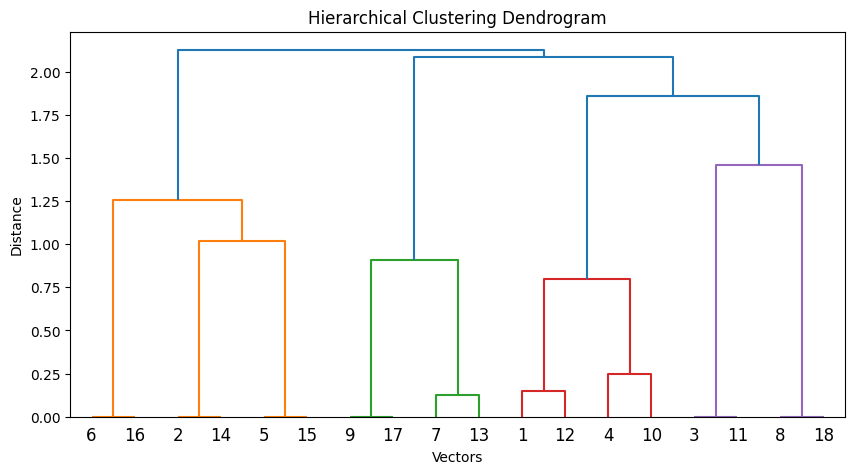

In [12]:
# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=emb_df['id'].values, orientation='top')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.show()

In [13]:
def rows_with_id(id):
    bundleId_of_id = df.loc[emb_df['id'] == id, 'bundleId'].iloc[0]
    return auctions_df[auctions_df['bundleId'] == bundleId_of_id]

In [14]:
#Extract the most similar pair - in case we dont have similar pairs with the same descriptions
#Mask out the diagonal (setting diagonal elements to a value that won't affect the maximum)
np.fill_diagonal(similarity_matrix, 0)

# Find the maximum similarity value
max_similarity = np.max(similarity_matrix)

# Find the indices of the maximum value
max_indices = np.argwhere(similarity_matrix == max_similarity)

# Extract the IDs of the most similar pair
most_similar_ids = [(index[0]+1, index[1]+1) for index in max_indices]

In [15]:
def find_pairs_with_similarity_one(similarity_matrix):
    np.fill_diagonal(similarity_matrix, 0)
    rounded_matrix = np.round(similarity_matrix, 3)
    pairs = []
    n = similarity_matrix.shape[0]  # Assuming the matrix is square

    for i in range(n):
        for j in range(i + 1, n):  # Iterate over the upper triangular part
            if rounded_matrix[i, j] == 1:
                pairs.append((i+1, j+1))
    return pairs

In [16]:
sim_one = find_pairs_with_similarity_one(similarity_matrix)

## Graphs and tests
We will show on the first pair that we found the statistics and the similarity of the distributions

In [17]:
#Lets take two similar  as an example of two similar choices
if sim_one is None or len(sim_one) == 0:
    first = most_similar_ids[0]
else:
    first = sim_one[0]
df_1 = rows_with_id(first[0])
df_2 = rows_with_id(first[1])

In [18]:
def plot_hist_and_box(df_1, df_2, category, bins):

    # Create subplots for df_1
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot histogram for df_1
    axs[0].hist(df_1[category], bins=bins, color='skyblue', edgecolor='black')
    axs[0].set_title('Histogram of sentPrice for ' + df_1.iloc[0]['bundleId'])
    axs[0].set_xlabel(category)
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)
    
    # Plot box plot for df_1
    axs[1].boxplot(df_1[category])
    axs[1].set_title('Box plot of sentPrice for ' + df_1.iloc[0]['bundleId'][0])
    axs[1].set_ylabel(category)
    axs[1].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Create subplots for df_2
    fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot histogram for def_2
    axs2[0].hist(df_2[category], bins=bins, color='salmon', edgecolor='black')
    axs2[0].set_title('Histogram of sentPrice for ' + df_2.iloc[0]['bundleId'][0])
    axs2[0].set_xlabel(category)
    axs2[0].set_ylabel('Frequency')
    axs2[0].grid(True)
    
    # Plot box plot for df_2
    axs2[1].boxplot(df_2[category])
    axs2[1].set_title('Box plot of sentPrice for ' + df_2.iloc[0]['bundleId'][0])
    axs2[1].set_ylabel(category)
    axs2[1].grid(True)
    
    # Adjust layout for df_2
    plt.tight_layout()
    
    # Show the plots
    plt.show()

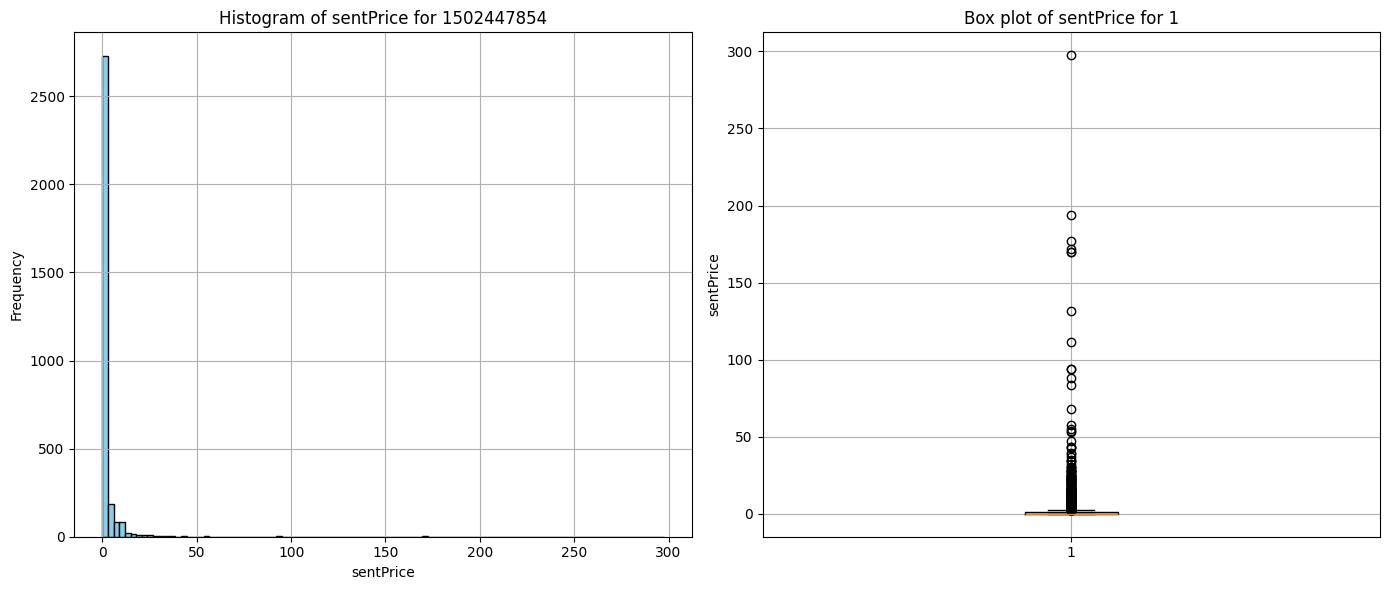

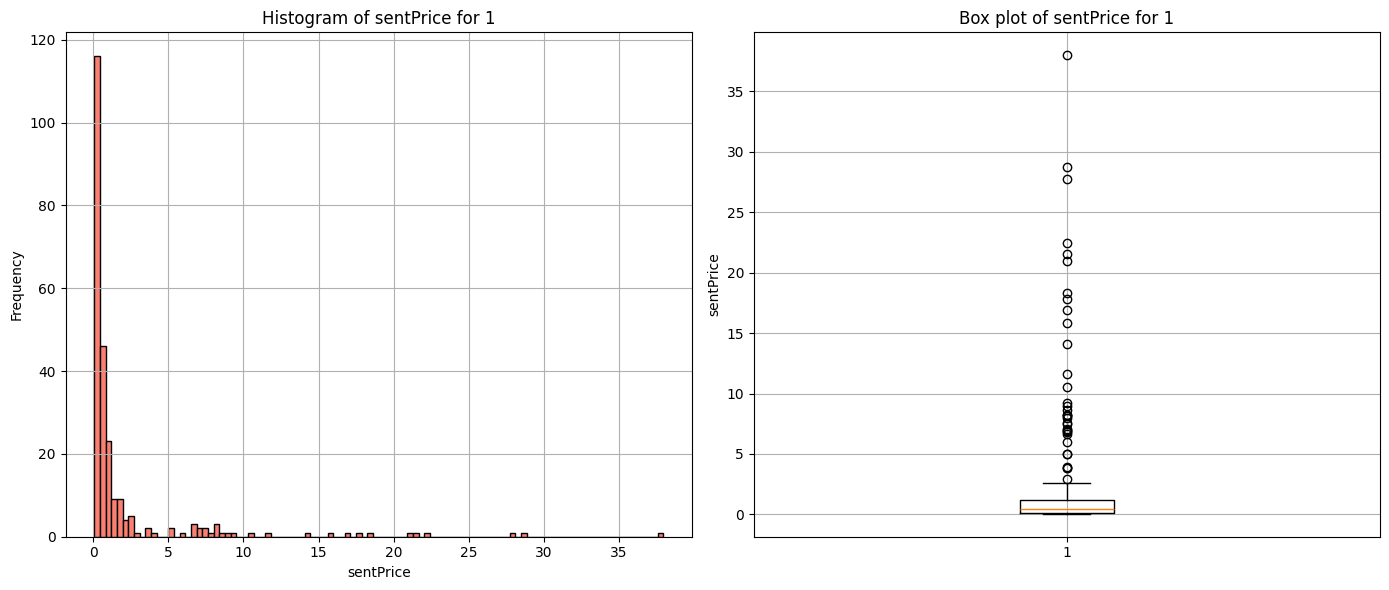

In [19]:
plot_hist_and_box(df_1, df_2, 'sentPrice', 100)

In [20]:
def statistics(df_1, df_2, to_print):
    # Statistical Tests
    ks_statistic, ks_pvalue = stats.ks_2samp(df_1['sentPrice'], df_2['sentPrice'])
    mw_statistic, mw_pvalue = stats.mannwhitneyu(df_1['sentPrice'], df_2['sentPrice'])
    
    if to_print:
        # Descriptive Statistics
        stats_df_1 = df_1['sentPrice'].describe()
        stats_df_2 = df_2['sentPrice'].describe()
        print("Descriptive Statistics for df_1:")
        print(stats_df_1)
        print("\nDescriptive Statistics for df_2:")
        print(stats_df_2)
        print("\nStatistical Test Results:")
        print("Kolmogorov-Smirnov Test:")
        print(f"   Statistic: {ks_statistic}, p-value: {ks_pvalue}")
        print("Mann-Whitney U Test:")
        print(f"   Statistic: {mw_statistic}, p-value: {mw_pvalue}")
    
    return ks_pvalue>0.05, mw_pvalue>0.05

In [21]:
statistics(df_1, df_2, 1)

Descriptive Statistics for df_1:
count    3185.000000
mean        2.269482
std        10.811221
min         0.010000
25%         0.040000
50%         0.160000
75%         0.910000
max       297.500000
Name: sentPrice, dtype: float64

Descriptive Statistics for df_2:
count    246.000000
mean       2.114797
std        4.992723
min        0.050000
25%        0.130000
50%        0.465000
75%        1.170000
max       37.980000
Name: sentPrice, dtype: float64

Statistical Test Results:
Kolmogorov-Smirnov Test:
   Statistic: 0.271585557299843, p-value: 2.333128093488801e-15
Mann-Whitney U Test:
   Statistic: 287306.0, p-value: 2.8947113103912414e-12


(False, False)

Explenations about the statistical tests I chose to use

## Kolmogorov-Smirnov Test (KS Test):

The Kolmogorov-Smirnov (KS) test is a non-parametric statistical test used to compare the distributions of two samples. It quantifies the maximum vertical distance between the cumulative distribution functions (CDFs) of the two samples. The KS test is sensitive to differences in both location and shape of the empirical cumulative distribution functions.

- **Statistic**: The KS statistic quantifies the maximum vertical distance between the CDFs of the two samples. Larger values indicate larger differences between the distributions.
- **p-value**: The p-value indicates the probability of obtaining the observed KS statistic (or a more extreme value) if the null hypothesis were true. If the p-value is below a significance level (e.g., 0.05), we reject the null hypothesis, suggesting that the distributions are significantly different.

## Mann-Whitney U Test:

The Mann-Whitney U test, also known as the Wilcoxon rank-sum test, is a non-parametric test used to determine whether there is a significant difference between the distributions of two independent samples. It compares the ranks of observations in the two samples and is sensitive to differences in location (median) between the samples.

- **Statistic**: The Mann-Whitney U statistic represents the U value of the test, which is based on the ranks of the observations in the combined sample. Higher values suggest larger differences between the distributions.
- **p-value**: The p-value indicates the probability of obtaining the observed U statistic (or a more extreme value) if the null hypothesis (no difference between distributions) were true. A low p-value suggests significant differences between the distributions.


We will now check all of the similar pairs to see if there is a connection that we mught have missed.

In [22]:
to_print = 1
ks_mw = np.zeros((len(sim_one), 2))
for i, sim in enumerate(sim_one):
    df_1 = rows_with_id(sim[0])
    df_2 = rows_with_id(sim[1])
    ks_mw[i,:] = statistics(df_1, df_2, to_print)
    # plot_hist_and_box(df_1, df_2, 'sentPrice', 100)
print("The number of tests that shows similarity of the distributions between the similar apps is: " + str(ks_mw.sum()))

Descriptive Statistics for df_1:
count    3185.000000
mean        2.269482
std        10.811221
min         0.010000
25%         0.040000
50%         0.160000
75%         0.910000
max       297.500000
Name: sentPrice, dtype: float64

Descriptive Statistics for df_2:
count    246.000000
mean       2.114797
std        4.992723
min        0.050000
25%        0.130000
50%        0.465000
75%        1.170000
max       37.980000
Name: sentPrice, dtype: float64

Statistical Test Results:
Kolmogorov-Smirnov Test:
   Statistic: 0.271585557299843, p-value: 2.333128093488801e-15
Mann-Whitney U Test:
   Statistic: 287306.0, p-value: 2.8947113103912414e-12
Descriptive Statistics for df_1:
count    424.000000
mean       3.121816
std       13.546923
min        0.010000
25%        0.020000
50%        0.110000
75%        1.037500
max      168.420000
Name: sentPrice, dtype: float64

Descriptive Statistics for df_2:
count    1650.000000
mean        0.445255
std         0.872778
min         0.010000
25%  

## Conclusion

What we can deduce from the statistical tests that we conducted is that there is no similarity in the distribution of the 'sentPrice' among similar embedded app descriptions. Therefore, we conclude that the hypothesis stating that apps with similar descriptions would have a similar asking price in the auctions is not correct.





# Second Phase
## Question
We will now ask if there is a connection/correlation between `countryCode` or `osAndVersion` and the sentPrice

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

We will show a graph of one of the countries, for example US, and the senPrice:

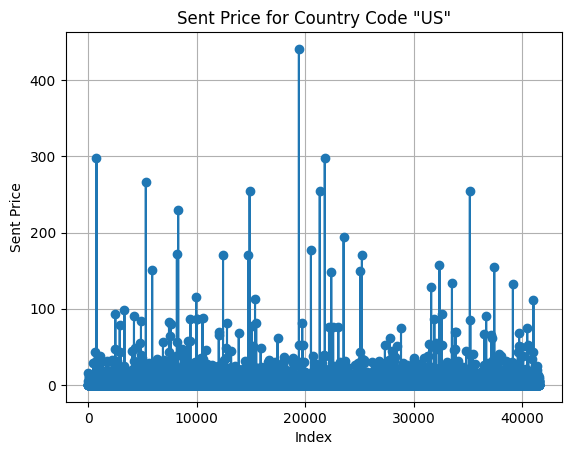

In [24]:
us_data = auctions_df[auctions_df['countryCode']=='US']

plt.plot(us_data.index, us_data['sentPrice'], marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Sent Price')
plt.title('Sent Price for Country Code "US"')
plt.grid(True)
plt.show()

That graph is enough to show that there are too many values that we get in sentPrice for the same country and therefore we can tell that the countyby herself can't be used to predict the sentPrice.

We can get the same thing for the osAndVersion:

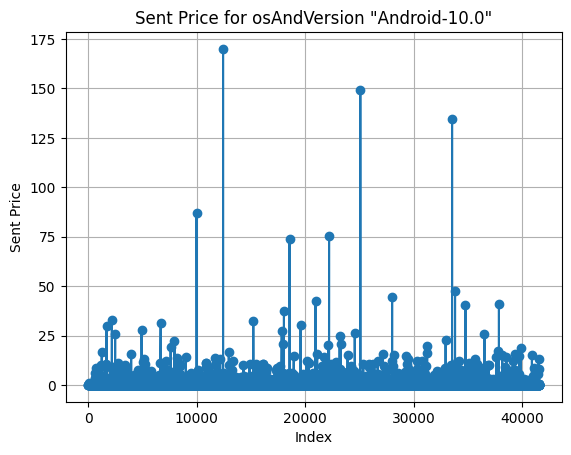

In [25]:
us_data = auctions_df[auctions_df['osAndVersion']=='Android-10.0']

plt.plot(us_data.index, us_data['sentPrice'], marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Sent Price')
plt.title('Sent Price for osAndVersion "Android-10.0"')
plt.grid(True)
plt.show()

We will now try and ask - what are the features that have large predictive power with regards to the target sentPrice?

## Data preperation

In [26]:
X = auctions_df.drop(columns=['sentPrice'])
y = auctions_df['sentPrice']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
unique_counts = {}

# Iterate over each column in the DataFrame
for column in X_train.columns:
    # Count the number of unique values for the current column
    unique_counts[column] = X_train[column].nunique()

# Convert the dictionary to a DataFrame for better visualization
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique_Count'])
unique_counts_df.index.name = 'Column_Name'

print("Number of unique values for each column:")
print(unique_counts_df)

Number of unique values for each column:
                 Unique_Count
Column_Name                  
id                      33267
eventTimestamp          33267
unitDisplayType             3
brandName                 137
bundleId                   18
countryCode               163
deviceId                33262
osAndVersion               91
bidFloorPrice               4


We can tell that the deviceId is different for almost every input, so we can drop it in our prediction.

In [28]:
# Drop 'deviceId' column from both X_train and X_test
X_train.drop(columns=['deviceId'], inplace=True)
X_test.drop(columns=['deviceId'], inplace=True)

# Convert 'eventTimestamp' column from string to integer in both X_train and X_test
X_train['eventTimestamp'] = X_train['eventTimestamp'].astype(int)
X_test['eventTimestamp'] = X_test['eventTimestamp'].astype(int)

In [29]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['unitDisplayType', 'brandName', 'bundleId', 'countryCode', 'osAndVersion']

combined_data = pd.concat([X_train, X_test])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column in both X_train and X_test
for column in columns_to_encode:
    # Fit LabelEncoder on X_train and transform X_train and X_test
    label_encoder.fit(combined_data[column])
    X_train[column] = label_encoder.transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])

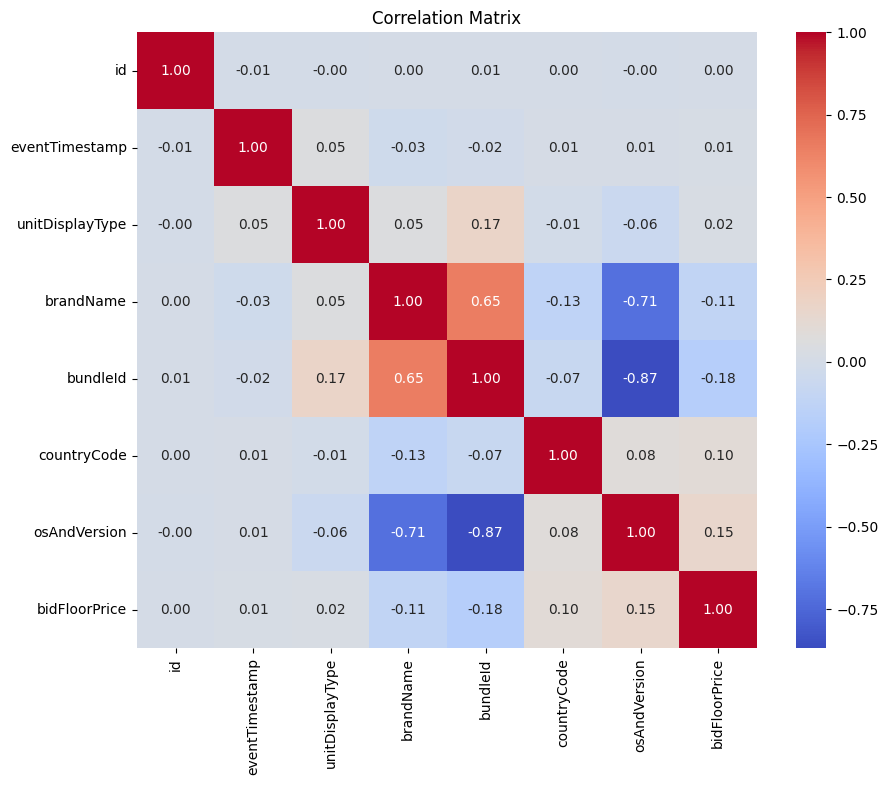

In [30]:
correlation_matrix = X_train.corr()

# If you want to visualize the correlation matrix, you can use a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [31]:
def remove_correlated_features(correlation_matrix, threshold=0.8, feature_to_keep=None):

    iters = range(len(correlation_matrix.columns) - 1)
    drop_cols = []
    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = correlation_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
                
    return drop_cols


In [32]:
drop_cols = remove_correlated_features(correlation_matrix, threshold=0.8, feature_to_keep='some_feature_name')
drop_cols

['osAndVersion']

We will try to train our model without dropping the osAndVersion for starters:

In [37]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [38]:
# Hyperparameters search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],             # Maximum tree depth
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate (eta)
    'subsample': [0.8, 0.9],            # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 0.9],     # Subsample ratio of columns when constructing each tree
}

In [42]:
def train_a_model(X_train, y_train, X_test, y_test):
    # Perform grid search with cross-validation
    xgb_model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Evaluate the model with best hyperparameters on the test set
    best_model = grid_search.best_estimator_
    return best_model

In [43]:
# Evaluate
best_model = train_a_model(X_train, y_train, X_test, y_test)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)
mean_absolute_error = np.mean(np.abs(y_test-y_pred))
print("Mean Absolute Error on Test Set:", mean_absolute_error)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Mean Squared Error on Test Set: 29.948424647841666
Mean Absolute Error on Test Set: 1.3752756833563191


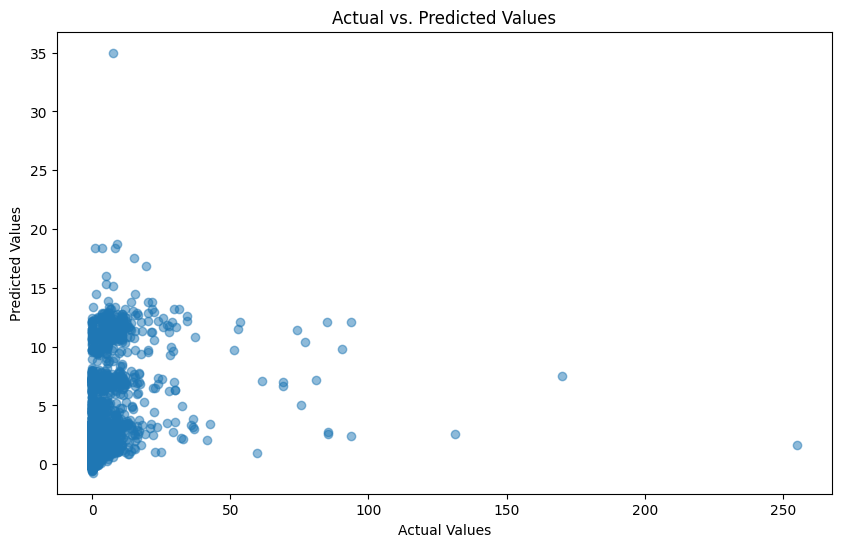

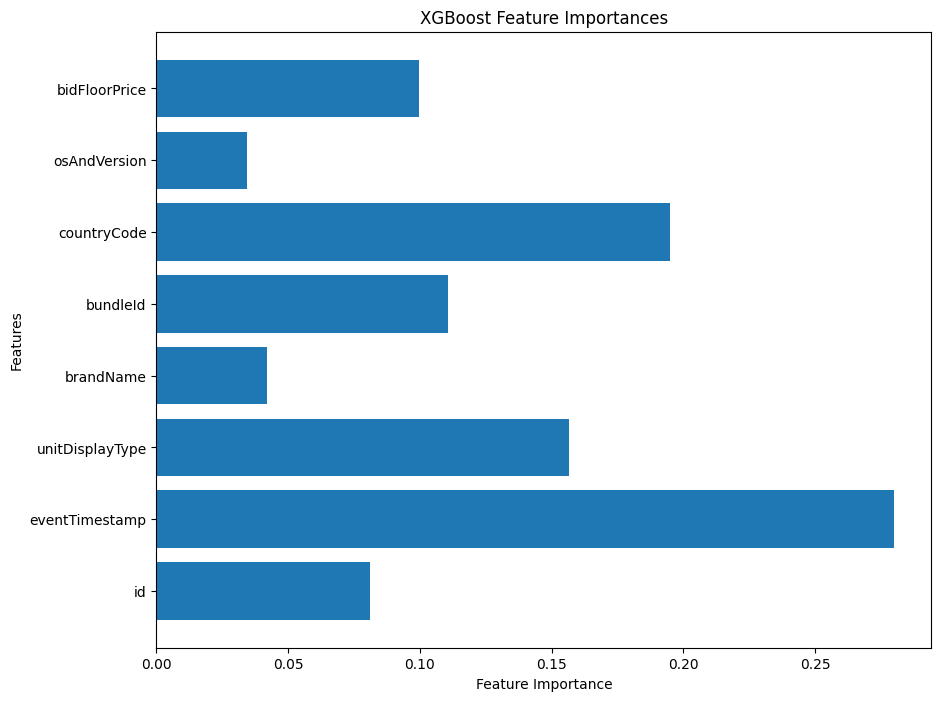

In [44]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Analyze feature importances
feature_importances = best_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importances')
plt.show()

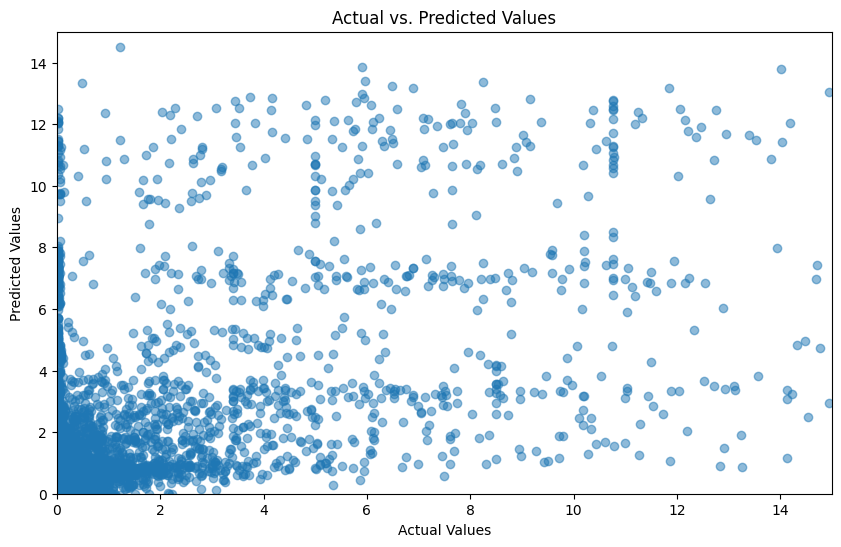

In [45]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [46]:
top_n_features = np.argsort(feature_importances)[::-1][:6]
X_train_selected = X_train.iloc[:, top_n_features]
X_test_selected = X_test.iloc[:, top_n_features]
# Evaluate
best_model = train_a_model(X_train_selected, y_train, X_test_selected, y_test)
y_pred = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)
mean_absolute_error = np.mean(np.abs(y_test-y_pred))
print("Mean Absolute Error on Test Set:", mean_absolute_error)

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Mean Squared Error on Test Set: 29.943840410358817
Mean Absolute Error on Test Set: 1.3634430387230236


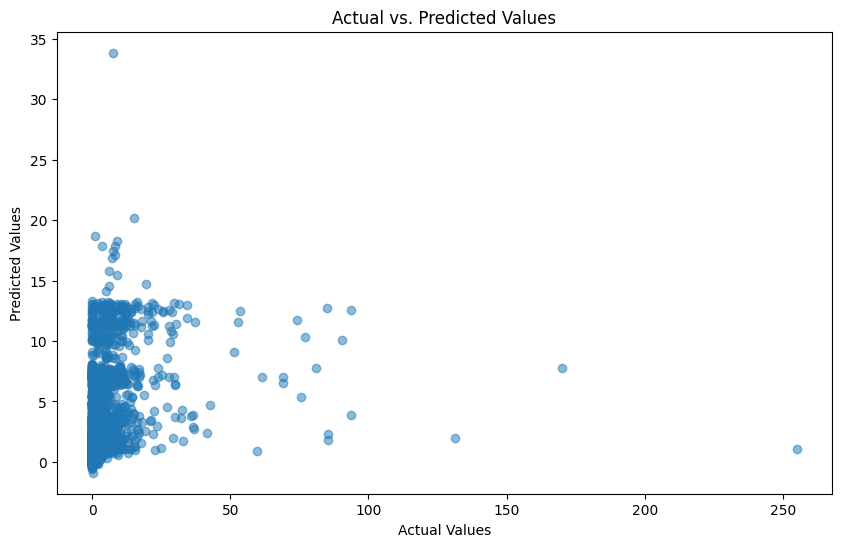

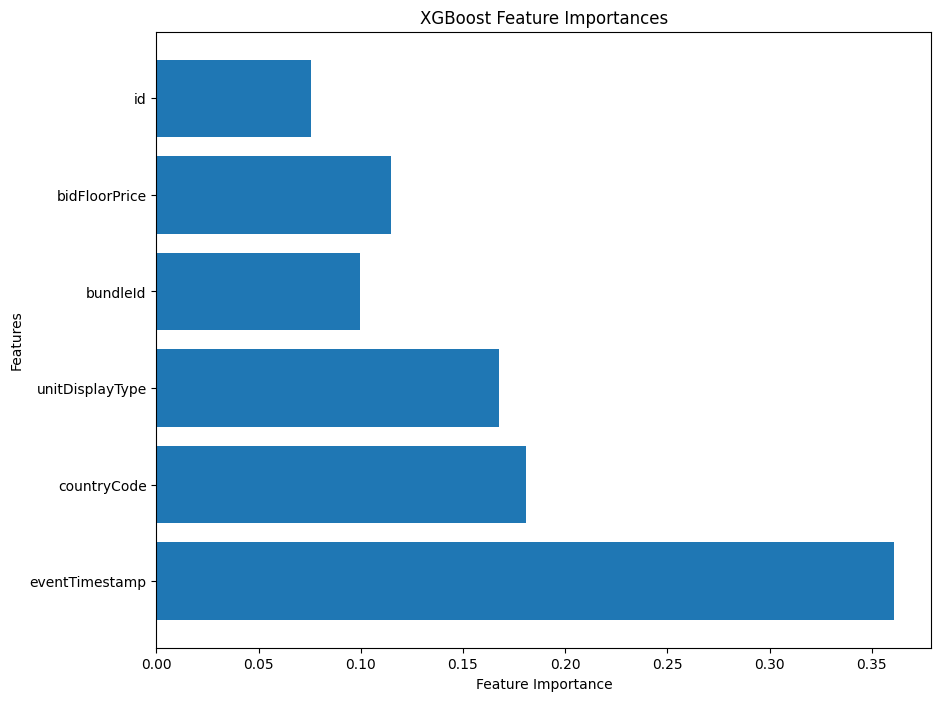

In [47]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Analyze feature importances
feature_importances = best_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(X_test_selected.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importances')
plt.show()

## Conclusion

Based on the feature importance analysis using XGBoost, it appears that no single feature can predict the `sentPrice` by itself. Among the features considered, `eventTimestamp` stands out as having relatively higher importance in predicting the `sentPrice`. However, it's important to note that accurate prediction likely depends on the combination of multiple features rather than any individual feature alone.

Moreover, it's crucial to exercise caution in interpreting these findings, particularly considering that the predictions obtained may not be very accurities.
